=== ADVANCED MODEL EXPERIMENTS ===
Data shape: (5630, 39)
Training set: (4504, 37)
Test set: (1126, 37)
Churn rate: 0.168

1. ADVANCED MODELS DEFINITION

2. HYPERPARAMETER OPTIMIZATION

--- Optimizing: Random Forest ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best CV Score: 0.9722
Test Accuracy: 0.9831
Test AUC: 0.9983
Average Precision: 0.9923

--- Optimizing: Gradient Boosting ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.15}
Best CV Score: 0.9695
Test Accuracy: 0.9902
Test AUC: 0.9988
Average Precision: 0.9920

--- Optimizing: XGBoost ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.15, 'colsample_bytree': 0.8}
Best C

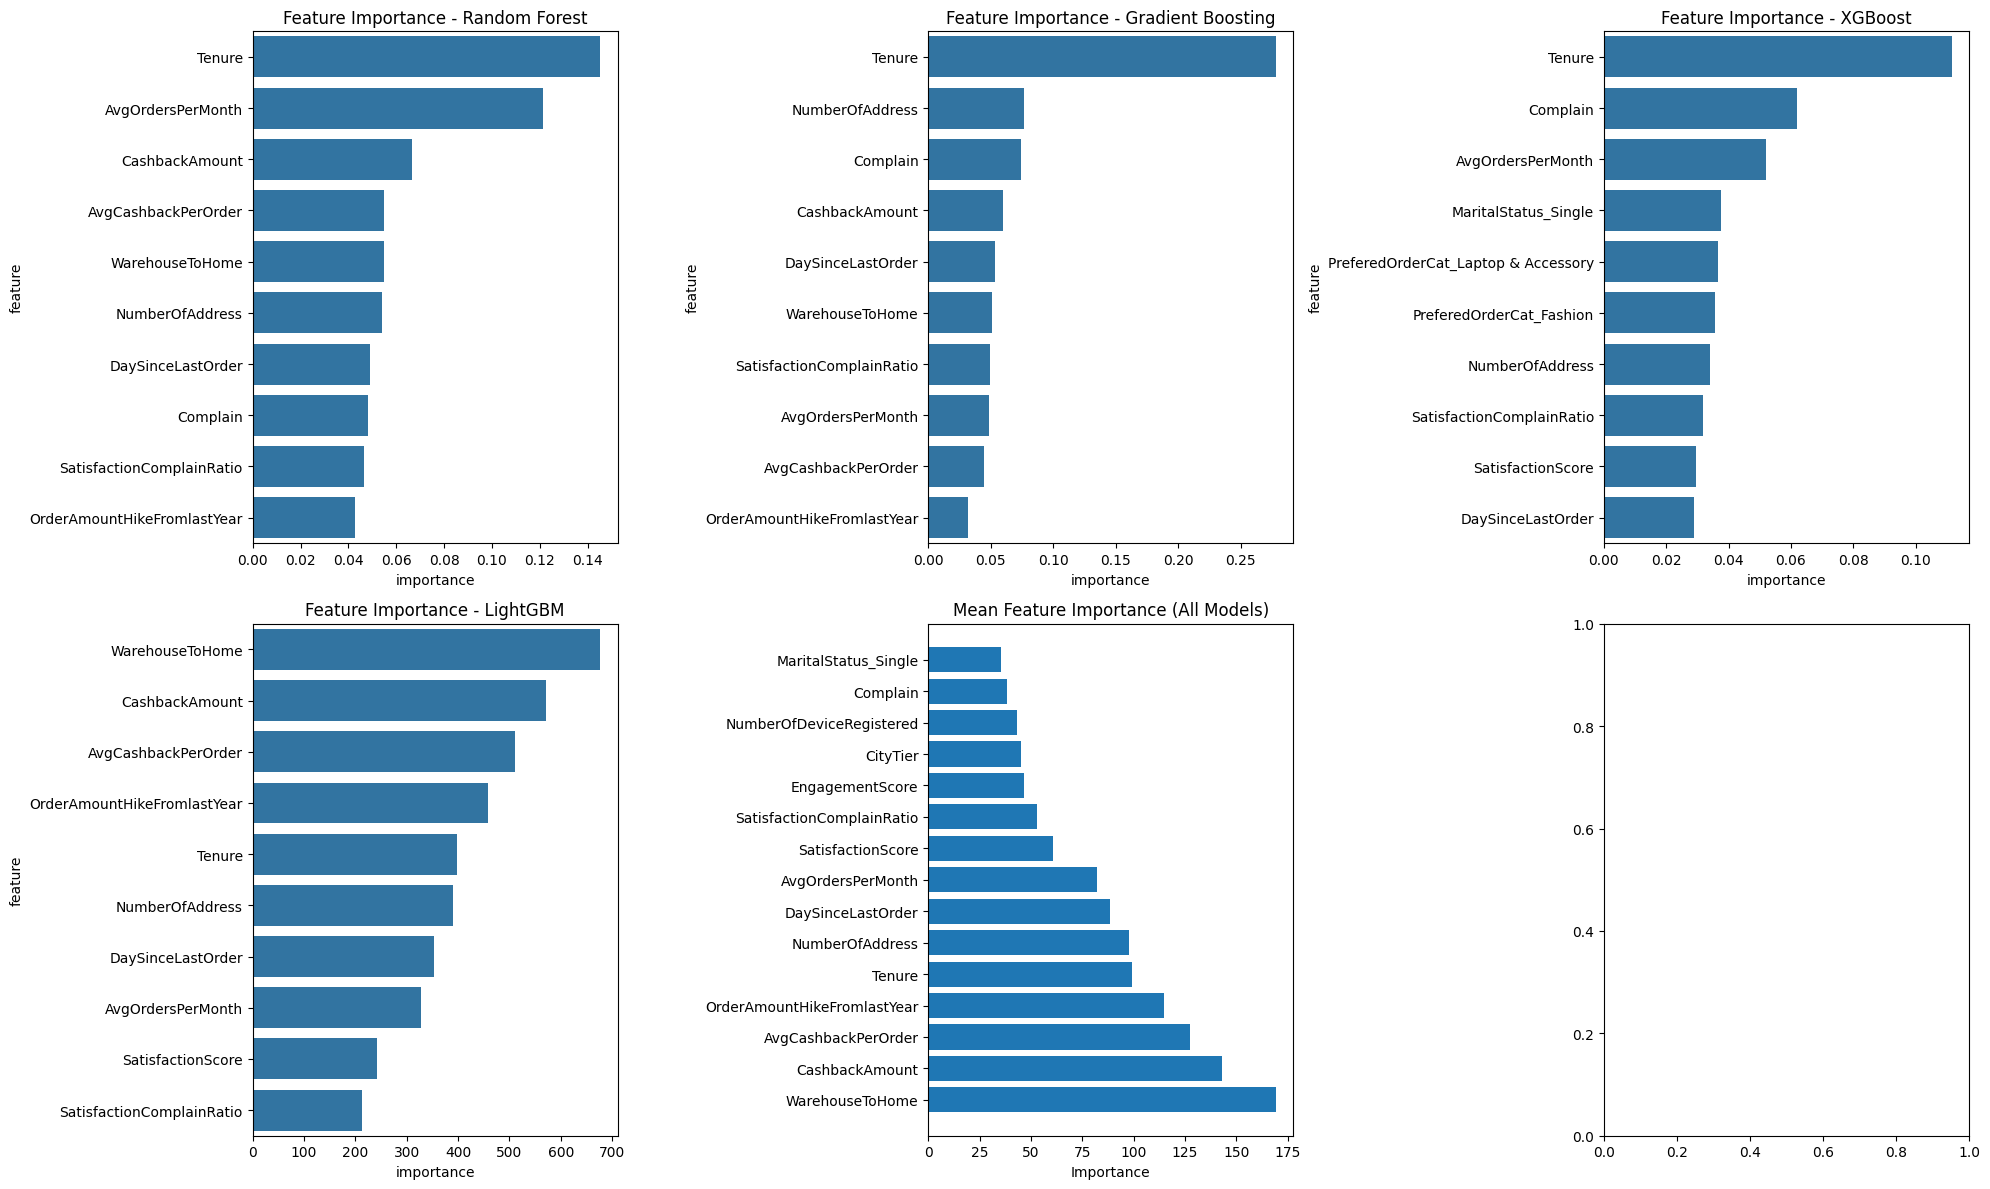


6. MODEL CALIBRATION AND VALIDATION


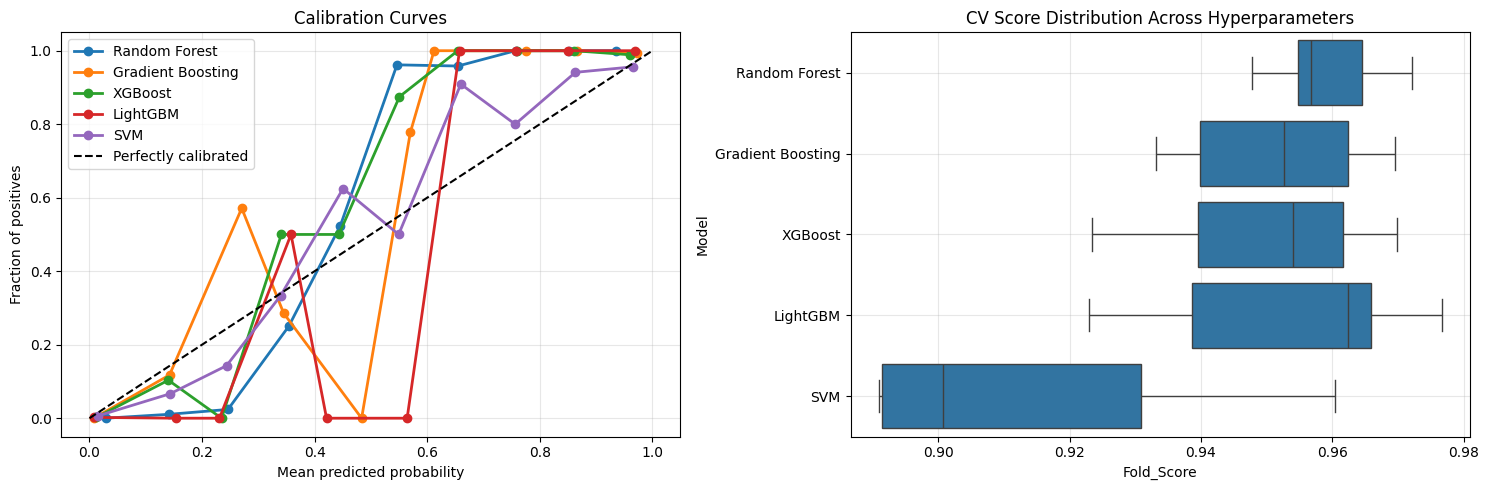


7. MODEL SELECTION AND INTERPRETATION
🎯 BEST ADVANCED MODEL: LightGBM
📊 Performance Metrics:
   - Test AUC: 0.9989
   - Test Accuracy: 0.9938
   - Average Precision: 0.9962
   - CV AUC: 0.9766

🔧 Best Hyperparameters:
   - subsample: 0.9
   - num_leaves: 31
   - n_estimators: 200
   - max_depth: 7
   - learning_rate: 0.1

📈 Statistical Confidence:
   - Mean CV AUC: 0.9549
   - 95% CI: [0.9476, 0.9622]

8. SAVING MODELS AND RESULTS
✓ Best advanced model saved
✓ Experiment results saved

✅ ADVANCED MODEL EXPERIMENTS COMPLETED!

Best model: LightGBM with AUC = 0.9989

Next steps:
1. Proceed to final model evaluation
2. Conduct business impact analysis
3. Prepare model for deployment


In [ ]:
# Advanced Model Experiments with Hyperparameter Optimization
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, average_precision_score
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')
from src.config.database import get_connection_string

print("=== ADVANCED MODEL EXPERIMENTS ===")

# Load data
engine = create_engine(get_connection_string())
query = "SELECT * FROM ml_ready_features"
df = pd.read_sql(query, engine)

print(f"Data shape: {df.shape}")

# Prepare data
X = df.drop(['Churn', 'CustomerID'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Churn rate: {y_train.mean():.3f}")

# 1. Advanced Models Definition
print("\n" + "="*50)
print("1. ADVANCED MODELS DEFINITION")
print("="*50)

advanced_models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 4, 5],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.05, 0.1, 0.15],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.05, 0.1],
            'num_leaves': [31, 63],
            'subsample': [0.8, 0.9]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    }
}

# 2. Hyperparameter Optimization
print("\n" + "="*50)
print("2. HYPERPARAMETER OPTIMIZATION")
print("="*50)

experiment_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, config in advanced_models.items():
    print(f"\n--- Optimizing: {name} ---")
    
    # Use RandomizedSearchCV for faster optimization
    search = RandomizedSearchCV(
        config['model'], 
        config['params'], 
        n_iter=20,  # Reduced for speed
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    
    # Get best model
    best_model = search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = best_model.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Cross-validation scores
    cv_scores = search.cv_results_['mean_test_score']
    
    print(f"Best parameters: {search.best_params_}")
    print(f"Best CV Score: {search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test AUC: {auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    
    # Store results
    experiment_results[name] = {
        'model': best_model,
        'search': search,
        'best_params': search.best_params_,
        'best_cv_score': search.best_score_,
        'accuracy': accuracy,
        'auc': auc,
        'avg_precision': avg_precision,
        'cv_scores': cv_scores,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# 3. Comprehensive Results Analysis
print("\n" + "="*50)
print("3. COMPREHENSIVE RESULTS ANALYSIS")
print("="*50)

# Create results comparison
results_data = []
for name, results in experiment_results.items():
    results_data.append({
        'Model': name,
        'CV_AUC_Mean': results['best_cv_score'],
        'Test_AUC': results['auc'],
        'Test_Accuracy': results['accuracy'],
        'Avg_Precision': results['avg_precision'],
        'Best_Params': str(results['best_params'])[:100] + '...'  # Truncate for display
    })

results_df = pd.DataFrame(results_data).sort_values('Test_AUC', ascending=False)
print("Advanced Models Comparison:")
print(results_df.to_string(index=False))

# 4. Feature Importance Analysis
print("\n" + "="*50)
print("4. FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Analyze feature importance across models
feature_importance_results = {}

for name, results in experiment_results.items():
    model = results['model']
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_,
            'model': name
        }).sort_values('importance', ascending=False)
        feature_importance_results[name] = importance_df

# Plot feature importance comparison
if feature_importance_results:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, (name, importance_df) in enumerate(feature_importance_results.items()):
        if idx < 6:  # Limit to 6 subplots
            top_features = importance_df.head(10)
            sns.barplot(data=top_features, x='importance', y='feature', ax=axes[idx])
            axes[idx].set_title(f'Feature Importance - {name}')
    
    # Combined feature importance (mean across models)
    combined_importance = pd.concat([df.assign(model=name) for name, df in feature_importance_results.items()])
    mean_importance = combined_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).head(15)
    
    if len(axes) > len(feature_importance_results):
        axes[len(feature_importance_results)].barh(range(len(mean_importance)), mean_importance.values)
        axes[len(feature_importance_results)].set_yticks(range(len(mean_importance)))
        axes[len(feature_importance_results)].set_yticklabels(mean_importance.index)
        axes[len(feature_importance_results)].set_title('Mean Feature Importance (All Models)')
        axes[len(feature_importance_results)].set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()

# 5. Learning Curves and Model Calibration
print("\n" + "="*50)
print("5. MODEL CALIBRATION AND VALIDATION")
print("="*50)

from sklearn.calibration import calibration_curve

# Calibration analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for name, results in experiment_results.items():
    prob_true, prob_pred = calibration_curve(y_test, results['probabilities'], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Performance stability across CV folds
plt.subplot(1, 2, 2)
cv_stability_data = []
for name, results in experiment_results.items():
    search_results = results['search']
    for fold_idx in range(len(search_results.cv_results_['mean_test_score'])):
        cv_stability_data.append({
            'Model': name,
            'Fold_Score': search_results.cv_results_['mean_test_score'][fold_idx],
            'Params': str(search_results.cv_results_['params'][fold_idx])[:50]
        })

cv_stability_df = pd.DataFrame(cv_stability_data)
sns.boxplot(data=cv_stability_df, x='Fold_Score', y='Model')
plt.title('CV Score Distribution Across Hyperparameters')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Model Selection and Interpretation
print("\n" + "="*50)
print("6. MODEL SELECTION AND INTERPRETATION")
print("="*50)

# Select best model based on test AUC
best_model_name = results_df.iloc[0]['Model']
best_model_results = experiment_results[best_model_name]

print(f"🎯 BEST ADVANCED MODEL: {best_model_name}")
print(f"📊 Performance Metrics:")
print(f"   - Test AUC: {best_model_results['auc']:.4f}")
print(f"   - Test Accuracy: {best_model_results['accuracy']:.4f}")
print(f"   - Average Precision: {best_model_results['avg_precision']:.4f}")
print(f"   - CV AUC: {best_model_results['best_cv_score']:.4f}")

print(f"\n🔧 Best Hyperparameters:")
for param, value in best_model_results['best_params'].items():
    print(f"   - {param}: {value}")

# Statistical confidence intervals
def calculate_confidence_interval(scores, confidence=0.95):
    n = len(scores)
    mean = np.mean(scores)
    sem = stats.sem(scores)
    h = sem * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - h, mean + h

best_cv_scores = best_model_results['search'].cv_results_['mean_test_score']
best_mean, best_lower, best_upper = calculate_confidence_interval(best_cv_scores)

print(f"\n📈 Statistical Confidence:")
print(f"   - Mean CV AUC: {best_mean:.4f}")
print(f"   - 95% CI: [{best_lower:.4f}, {best_upper:.4f}]")

# 7. Save Best Model and Results
print("\n" + "="*50)
print("7. SAVING MODELS AND RESULTS")
print("="*50)

import joblib
import json
import os

# Create directories
os.makedirs('../models/advanced', exist_ok=True)
os.makedirs('../models/final', exist_ok=True)

# Save best advanced model
joblib.dump(best_model_results['model'], f'../models/advanced/best_advanced_model.pkl')

# Save all experiment results
experiment_summary = {
    'best_model': best_model_name,
    'best_auc': best_model_results['auc'],
    'comparison_table': results_df.to_dict(),
    'feature_importance': {
        name: df.head(10).to_dict() for name, df in feature_importance_results.items()
    } if feature_importance_results else {}
}

with open('../models/advanced/experiment_results.json', 'w') as f:
    json.dump(experiment_summary, f, indent=2)

print("✓ Best advanced model saved")
print("✓ Experiment results saved")

print("\n✅ ADVANCED MODEL EXPERIMENTS COMPLETED!")
print(f"\nBest model: {best_model_name} with AUC = {best_model_results['auc']:.4f}")
print("\nNext steps:")
print("1. Proceed to final model evaluation")
print("2. Conduct business impact analysis")
print("3. Prepare model for deployment")